# Soccer - PPO

---


### 1. Setup Environment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.distributions as distributions
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from collections import deque
import datetime
import pytz

import numpy as np
import matplotlib.pyplot as plt

def get_time(format):
    utc_now = pytz.utc.localize(datetime.datetime.utcnow())
    pst_now = utc_now.astimezone(pytz.timezone("America/Los_Angeles"))
    return pst_now.strftime(format)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### 2. Load Unity Soccer Game

Environments contain **_brains_** which are responsible for deciding the actions of their agents. Here we obtain separate brains for the striker and goalie agents and examine the state and action spaces.

In [2]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="Soccer_Linux_NoVis/Soccer.x86_64.app", seed=1)
#env = UnityEnvironment(file_name="Soccer.app", seed=0)

# set the goalie brain
g_brain_name = env.brain_names[0]
g_brain = env.brains[g_brain_name]

# set the striker brain
s_brain_name = env.brain_names[1]
s_brain = env.brains[s_brain_name]

# reset the environment
env_info = env.reset(train_mode=True)

# number of agents 
num_g_agents = len(env_info[g_brain_name].agents)
print('Number of goalie agents:', num_g_agents)
num_s_agents = len(env_info[s_brain_name].agents)
print('Number of striker agents:', num_s_agents)

# number of actions
g_action_size = g_brain.vector_action_space_size
print('Number of goalie actions:', g_action_size)
s_action_size = s_brain.vector_action_space_size
print('Number of striker actions:', s_action_size)

# examine the state space 
g_states = env_info[g_brain_name].vector_observations
g_state_size = g_states.shape[1]
print('There are {} goalie agents. Each receives a state with length: {}'.format(g_states.shape[0], g_state_size))
s_states = env_info[s_brain_name].vector_observations
s_state_size = s_states.shape[1]
print('There are {} striker agents. Each receives a state with length: {}'.format(s_states.shape[0], s_state_size))


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 2
        Number of External Brains : 2
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: GoalieBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
Unity brain name: StrikerBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 112
        Number of stacked Vector Observation: 3
        Vector Action space type: discrete
        Vector Action space size (per agent): 6
        Vector Action descriptions: , , , , , 


Number of goalie agents: 2
Number of striker agents: 2
Number of goalie actions: 4
Number of striker actions: 6
There are 2 goalie agents. Each receives a state with length: 336
There are 2 striker agents. Each receives a state with length: 336


### 3. Setup Actor and Critic Networks

The <strong>actor</strong> receives his own state space and outputs an action, the log probability of that action (to be used later in calculating the advantage ratio) and the entropy of the probability distribution. Higher entropy indicates more uncertainty in the probabilities. For example, when the probability of the goalie choosing 1 of the 4 possible actions is roughly equal (25% each), this would be maximum entropy. When one of those actions has 100% probability and the other 3 actions have 0% probability, the agent is absolutely certain and entropy will be zero. 

We use <strong>entropy</strong> as noise in the loss function to force the agent to try more random actions early on and not get fixated on a solution which is not optimal in the long run (stuck in a local minima.)

The <strong>critic</strong> receives the combined state space of all 4 agents on the field and outputs the expected average value (total reward) for an action taken given that state. We will use this value to compare to the actual total reward received from an actor's action. This will tell us how much better the chosen action (the advantage) is compared to the average likely reward.

A note on the distributions function:

It is not possible to have the actor simply output a softmax distribution of action probabilities and then choose an action off a random sampling of those probabilities. Neural networks cannot directly backpropagate through random samples. PyTorch and Tensorflow offer a <a href="https://pytorch.org/docs/stable/distributions.html">distribution function</a> to solve this that makes the action selection differentiable. The actor passes the softmax output through this distribution function to select the action and then backpropagation can occur.

In [3]:
def layer_init(layer, w_scale=1.0):
    nn.init.orthogonal_(layer.weight.data)
    layer.weight.data.mul_(w_scale)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class Actor(nn.Module):

    def __init__(self, state_size, action_size, hidden_0, hidden_1):
        super(Actor, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, action_size))
        
    def forward(self, x, action=None):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        
        dist = distributions.Categorical(x)

        if action is None:
            action = dist.sample()
        
        log_prob = dist.log_prob(action)

        return action, log_prob, dist.entropy()
    
class Critic(nn.Module):

    def __init__(self, state_size, hidden_0, hidden_1):
        super(Critic, self).__init__()
               
        self.fc1 = layer_init(nn.Linear(state_size*4, hidden_0))
        self.fc2 = layer_init(nn.Linear(hidden_0, hidden_1))
        self.fc3 = layer_init(nn.Linear(hidden_1, 1))

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 4. Policy Improvement Function

The learning process takes the experiences from the agents playing one full soccer game. This is either play until a goal was scored or 600 time steps passed and the game was terminated.

In [4]:
def learn(epochs, batch_size, actor, critic, optimizer, old_probs, all_states, states, actions, rewards, discount, epsilon, beta):

    '''
    Calculate the total reward earned for each time step. This is the actual reward earned at that time step,
    plus all the discounted future rewards earned after that time step to the end of the game.
    '''
    discount = discount**np.arange(len(rewards))
    rewards = rewards * discount
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
     # setup torch tensors
    states = torch.tensor(states).float().to(device)
    all_states = torch.stack(all_states)
    all_states = all_states.view(-1, g_state_size*4)
    actions = torch.tensor(actions).long().to(device).detach()
    old_probs = torch.tensor(old_probs).float().to(device).detach()
    rewards = torch.from_numpy(np.array(rewards_future)).float().to(device).detach()
    
    '''
    For Advantage Actor Critic (A2C) we want the agent to take actions which achieve the greatest reward compared
    to the average expected reward for that state (as estimated by our critic.) We compute the advantage function
    below and normalize it to improve training.
    '''
    values = critic_values(critic, all_states)
    advantages = (rewards - values).detach()
    advantages_normalized = (advantages - advantages.mean()) / (advantages.std() + 1.0e-10)
    advantages_normalized = torch.tensor(advantages_normalized).float().to(device)

    episode_loss = []
    avg_loss = 0

    '''
    We now will learn from this one game's set of experiences a certain number of times (epochs).
    Within the epoch we take the full set of game experiences and break them into random mini-batches to train on.
    '''
    for _ in range(epochs):
        
        batch = BatchSampler(SubsetRandomSampler(range(states.size(0))), batch_size, drop_last=False)

        for batch_indices in batch:
            batch_indices = torch.tensor(batch_indices).long().to(device)
            sampled_states = states[batch_indices]
            sampled_all_states = all_states[batch_indices]
            sampled_actions = actions[batch_indices]
            sampled_old_probs = old_probs[batch_indices]
            sampled_rewards = rewards[batch_indices]
            sampled_advantages = advantages_normalized[batch_indices]

            # get new probability of each action given the state and latest actor policy
            _, log_probs, entropy = actor(sampled_states, sampled_actions)
    
            # ratio - how much more likely is the new action choice vs. old choice according to our updated actor
            ratio = (log_probs - sampled_old_probs).exp()

            '''
            The clipping function makes sure that we don't update our weights too much when we find a much better 
            choice. Keep it within a set limit so we don't accidentally go off the rails following a false lead.
            This is the heart of Proximal Policy Optimization (PPO). It creates a more stable training environment.
            
            Our policy loss, therefore, is going to be the computed advantage of our action, but clipped if it is
            too big a move.
            '''
            clip = torch.clamp(ratio, 1-epsilon, 1+epsilon)
        
            policy_loss = torch.min(ratio*sampled_advantages, clip*sampled_advantages)
            policy_loss = -torch.mean(policy_loss)
        
            '''
            Entropy regularization term steers the new policy towards equal probability of all actions, encouraging
            exploration early on, but decreasing in importance over time. See above explanation under "Setup Actor
            and Critic Networks."
            '''
            entropy = torch.mean(entropy)

            # get predicted future rewards to use in backpropagation to improve the critic's estimates
            values = critic(sampled_all_states) 
            value_loss = F.mse_loss(sampled_rewards, values.view(-1))
            
            '''
            The loss function combines the policy loss with value loss and adds the entropy term. PyTorch will
            backpropagate the respective losses through to each network's parameters and optimize over time.
            '''
            loss = policy_loss + (0.5 * value_loss) - (entropy*beta)
            
            optimizer.zero_grad()
            loss.backward()
            # nn.utils.clip_grad_norm_(actor.parameters(), .5)
            optimizer.step()
    
            # some reporting to check performance
            if actor == striker_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value.append(torch.mean(entropy))
        
            if actor == goalie_0_actor:
                episode_loss.append(policy_loss.cpu().detach().numpy().squeeze().item())
                policy_loss_value_g.append(policy_loss.cpu().detach().numpy().squeeze().item())
                value_loss_value_g.append(value_loss.cpu().detach().numpy().squeeze().item())
                entropy_value_g.append(torch.mean(entropy))

    return np.array(episode_loss).mean()


# combine all 4 players' state spaces together for the critic
def combine_states(g_states, s_states):
    s_states = torch.from_numpy(s_states).float().to(device)
    g_states = torch.from_numpy(g_states).float().to(device)
    states_all = torch.cat((s_states, g_states), dim=1)
    states_all = states_all.view(-1, g_state_size*4)
    return states_all

#get an action from the actor for each step of game play (inference/eval only)
def act(actor, state):
    state = torch.from_numpy(state).float().to(device)
    state = state.view(-1, g_state_size)
    actor.eval()
    with torch.no_grad():
        action, log_prob, _ = actor(state)
    actor.train()
    log_prob = log_prob.cpu().detach().numpy().item()
    action = action.cpu().detach().numpy().item()
    return log_prob, action

# get critic values detached from the training process (eval/inference only)
def critic_values(critic, states):
    critic.eval()
    with torch.no_grad():
        values = critic(states).detach().squeeze()
    critic.train()
    return values

### 5. Train The Agents

In [5]:
episodes =  30000       # set to run a long time, will break when max avg return of 110.0 is reached
learning_rate = 8e-5    # shared actor/critic learning rate
discount = .995         # how much to reduce future rewards when calculating the current state's total reward
t_max = 600             # the soccer environment runs until 600 steps, then stops, if no goal is scored first
epochs = 1              # how many times to train off of one game's experiences
batch_size = 32         # how small to make the mini batches of a game's experiences when training

hidden_0 = 256          # first hidden layer size for actor and critic
hidden_1 = 128          # second hidden layer size for actor and critic

epsilon = .1            # how much to clip the advantage function
eps_decay = 1           # how fast to tighten the clipping function
beta = .001             # how much entropy to add to the loss for exploration
beta_decay = .995       # how fast to reduce the added entropy

In [ ]:
'''
The soccer environment has a goalie and striker for each of two teams. Here one team is being trained and the
other is taking random actions. If a goal is scored, the team gets 1.1 points. Otherwise, zero points for each team.
Over 100 games, the max possible score for a team is 110 (1.1 * 100). The trained team has been successfully
trained when it scores a goal and wins 100 consecutive games.
'''

# setup actor and critic for goalie and striker
striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
striker_0_critic = Critic(s_state_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)
goalie_0_critic = Critic(g_state_size, hidden_0, hidden_1).to(device)

striker_0_optimizer = optim.Adam(list(striker_0_actor.parameters()) + list(striker_0_critic.parameters()), lr=learning_rate)
goalie_0_optimizer = optim.Adam(list(goalie_0_actor.parameters()) + list(goalie_0_critic.parameters()), lr=learning_rate)

# some reporting to track losses and keep a 100 game rolling average of the trained team's score.
team_0_scores = deque(maxlen=100)
team_0_score = 0
rolling_average = []
policy_loss_value = []
value_loss_value = []
entropy_value = []
policy_loss_value_g = []
value_loss_value_g = []
entropy_value_g = []

print ("***STARTED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))

for e in range(episodes):                  
    
    all_state_list = []
    s_0_state_list = []
    g_0_state_list = []
    s_0_reward_list = []
    s_0_prob_list = []
    s_0_action_list = []
    g_0_reward_list = []
    g_0_prob_list = []
    g_0_action_list = []

    env_info = env.reset(train_mode=True)                     
    g_states = env_info[g_brain_name].vector_observations  
    s_states = env_info[s_brain_name].vector_observations  
    
    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    for i in range(t_max):
        
        # combine all 4 agents' state spaces together
        states_all = combine_states(g_states, s_states)
        
        # select actions and send to environment (best teams trained)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])

        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)              
        
        # get next states
        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        # get reward and store experience (s,a,r,p) in lists for each striker and goalie
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        all_state_list.append(states_all)
        
        s_0_state_list.append(s_states[0])
        g_0_state_list.append(g_states[0])
        s_0_reward_list.append(s_rewards[0])
        s_0_prob_list.append(s0_prob)
        s_0_action_list.append(s0_action)
        g_0_reward_list.append(g_rewards[0])
        g_0_prob_list.append(g0_prob)
        g_0_action_list.append(g0_action)
        
        #update scores
        g_scores += g_rewards
        s_scores += s_rewards
        
        # check if episode finished
        done = np.any(env_info[g_brain_name].local_done)  

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
        
    # calculate scores and running team lead
    team_0_score = g_scores[0] + s_scores[0]
    team_0_scores.append(team_0_score)
    rolling_average.append(np.sum(team_0_scores))
                
    # agents learn
    striker_loss = learn(epochs, batch_size, striker_0_actor, striker_0_critic, striker_0_optimizer, s_0_prob_list, all_state_list, s_0_state_list, s_0_action_list, s_0_reward_list, discount, epsilon, beta)
    goalie_loss = learn(epochs, batch_size, goalie_0_actor, goalie_0_critic, goalie_0_optimizer, g_0_prob_list, all_state_list, g_0_state_list, g_0_action_list, g_0_reward_list, discount, epsilon, beta)

    # tighten clipping and reduce exploration over time
    epsilon *= eps_decay                
    beta *= beta_decay
    
    print('Episode {}:\tSteps: {}\tTeam Score: {:.1f} \tAvg 100 Games: {:.1f}\tScores (G|S): {:.2f} | {:.2f}'.format(
                        e+1, i+1, team_0_score, np.sum(team_0_scores), np.sum(g_scores[0]), np.sum(s_scores[0])))

    if np.sum(team_0_scores) >= 110.0:
        print ("***FINISHED TRAINING AT {} ".format(get_time('%Y-%m-%d--%H:%M:%S')))
        print('Training complete!')
        break

### 6. Save Model

In [10]:
torch.save(striker_0_actor.state_dict(), 'checkpoint_striker_0_actor.pth')
torch.save(goalie_0_actor.state_dict(), 'checkpoint_goalie_0_actor.pth')
torch.save(striker_0_critic.state_dict(), 'checkpoint_striker_0_critic.pth')
torch.save(goalie_0_critic.state_dict(), 'checkpoint_goalie_0_critic.pth')

### 7. Graph Performance

When a team scores, they get 1.1 points. The trained team is near perfect when, over 100 games played, they score a goal every single time and reach an average of 110 points (1.1 * 100 games played.) By definition, this means the random team does not score a single time in 100 episodes nor does a game end with zero score after the max 600 time steps.

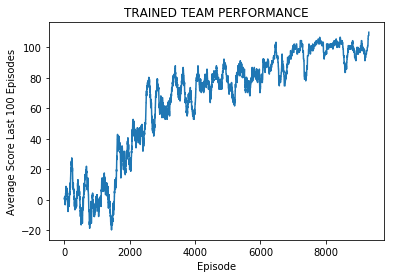

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(rolling_average)+1), rolling_average)
plt.title('TRAINED TEAM PERFORMANCE')
plt.ylabel('Average Score Last 100 Episodes')
plt.xlabel('Episode')
plt.show()

Policy loss for striker and goalie. It should stay in the range of (-1,1). Value loss and entropy should decline over time.

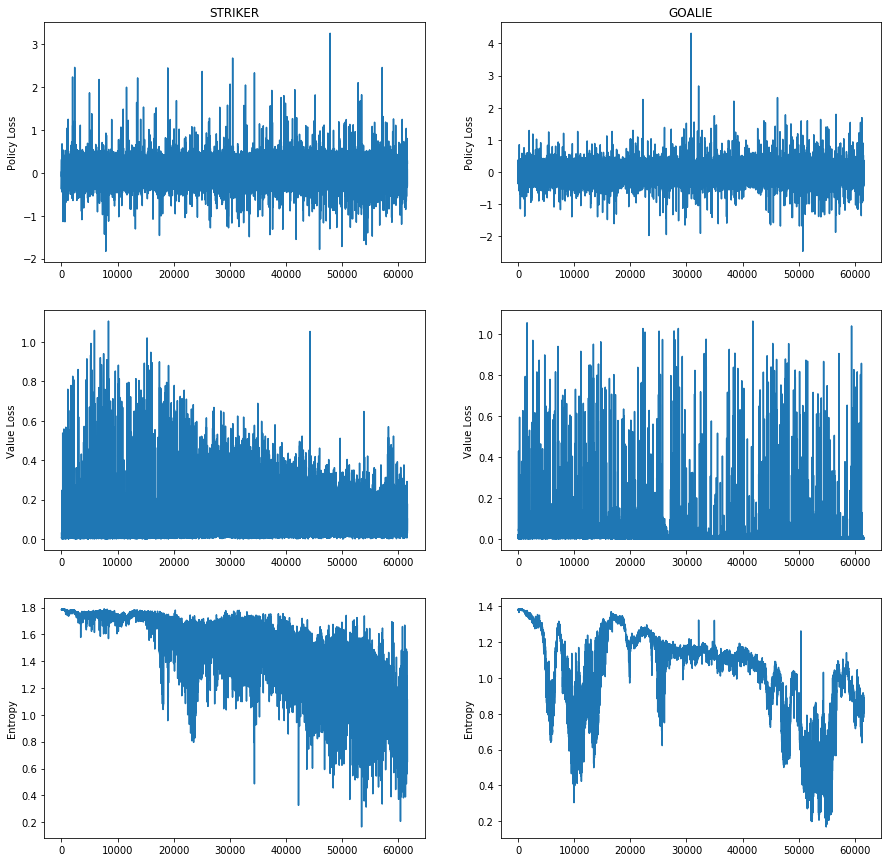

In [9]:
plt.figure(figsize=(15,15))

plt.subplot(3,2,1)
plt.plot(np.arange(1, len(policy_loss_value)+1), policy_loss_value)
plt.title('STRIKER')
plt.ylabel('Policy Loss')

plt.subplot(3,2,2)
plt.plot(np.arange(1, len(policy_loss_value_g)+1), policy_loss_value_g)
plt.title('GOALIE')
plt.ylabel('Policy Loss')

plt.subplot(3,2,3)
plt.plot(np.arange(1, len(value_loss_value)+1), value_loss_value)
plt.ylabel('Value Loss')

plt.subplot(3,2,4)
plt.plot(np.arange(1, len(value_loss_value_g)+1), value_loss_value_g)
plt.ylabel('Value Loss')

plt.subplot(3,2,5)
plt.plot(np.arange(1, len(entropy_value)+1), entropy_value)
plt.ylabel('Entropy')

plt.subplot(3,2,6)
plt.plot(np.arange(1, len(entropy_value_g)+1), entropy_value_g)
plt.ylabel('Entropy')

plt.show()

### 8. Watch The Trained Agents

The below code will load the trained actors (stiker and goalie) and run 100 games. A well trained team should win nearly all 100 games with a total score near 110. The other team is taking random actions.

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

striker_0_actor = Actor(s_state_size, s_action_size, hidden_0, hidden_1).to(device)
goalie_0_actor = Actor(g_state_size, g_action_size, hidden_0, hidden_1).to(device)

# Load the saved training parameters
striker_0_actor.load_state_dict(torch.load('checkpoint_striker_0_actor.pth', map_location='cpu'))
goalie_0_actor.load_state_dict(torch.load('checkpoint_goalie_0_actor.pth', map_location='cpu'))

# Set environment to evalulation mode
env_info = env.reset(train_mode=False)        
g_states = env_info[g_brain_name].vector_observations  
s_states = env_info[s_brain_name].vector_observations  

team_0_score = 0
team_1_score = 0
team_0_delta = 0
team_0_lead = []

print("*** Starting the first game ***")

for i in range(100):

    g_scores = np.zeros(num_g_agents)                      
    s_scores = np.zeros(num_s_agents)           

    while True:
        states_all = combine_states(g_states, s_states)
        g0_prob, g0_action = act(goalie_0_actor, g_states[0])
        s0_prob, s0_action = act(striker_0_actor, s_states[0])
        g_actions = np.array([g0_action, np.random.choice(g_action_size)])
        s_actions = np.array([s0_action, np.random.choice(s_action_size)])
        actions = dict(zip([g_brain_name, s_brain_name], [g_actions, s_actions]))
        env_info = env.step(actions)                       

        g_next_states = env_info[g_brain_name].vector_observations         
        s_next_states = env_info[s_brain_name].vector_observations

        done = np.any(env_info[g_brain_name].local_done)  
        
        #update scores
        g_rewards = env_info[g_brain_name].rewards  
        s_rewards = env_info[s_brain_name].rewards
        g_scores += g_rewards
        s_scores += s_rewards

        # exit loop if episode finished
        if done:                                           
            break

        # roll over states to next time step
        g_states = g_next_states
        s_states = s_next_states
    
    # calculate team scores and team 0 lead
    team_0_score = round(g_scores[0] + s_scores[0], 2)
    team_1_score = round(g_scores[1] + s_scores[1], 2)
    team_0_delta = round(team_0_score + team_0_delta, 2)
    team_0_lead.append(team_0_delta)
        
    print('Episode {}:\tTrained Team Score: {}      Cumulative Score: {}'.format(i+1, team_0_score, team_0_delta))

print("*** Last game finished ***")

*** Starting the first game ***
Episode 1:	Trained Team Score: 1.1      Cumulative Score: 1.1
Episode 2:	Trained Team Score: 1.1      Cumulative Score: 2.2
Episode 3:	Trained Team Score: 1.1      Cumulative Score: 3.3
Episode 4:	Trained Team Score: 1.1      Cumulative Score: 4.4
Episode 5:	Trained Team Score: 1.1      Cumulative Score: 5.5
Episode 6:	Trained Team Score: 1.1      Cumulative Score: 6.6
Episode 7:	Trained Team Score: 1.1      Cumulative Score: 7.7
Episode 8:	Trained Team Score: 1.1      Cumulative Score: 8.8
Episode 9:	Trained Team Score: 1.1      Cumulative Score: 9.9
Episode 10:	Trained Team Score: 1.1      Cumulative Score: 11.0
Episode 11:	Trained Team Score: 1.1      Cumulative Score: 12.1
Episode 12:	Trained Team Score: 1.1      Cumulative Score: 13.2
Episode 13:	Trained Team Score: 1.1      Cumulative Score: 14.3
Episode 14:	Trained Team Score: 1.1      Cumulative Score: 15.4
Episode 15:	Trained Team Score: 1.1      Cumulative Score: 16.5
Episode 16:	Trained Team S

When finished, you can close the environment.

In [ ]:
env.close()